<a href="https://colab.research.google.com/github/LeeYuuuan/yuanyuansrep/blob/main/two_disk_deep_Q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from matplotlib.ticker import MultipleLocator
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from enum import Enum


In [ ]:
class Actions(Enum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3
    STOP = 4

In [ ]:
class DQN_v0(nn.Module):
    def __init__(self, input_dim=4, output_dim=25):
        super(DQN_v0, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        # self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
import copy

In [ ]:
class DiskEnvironment:
    def __init__(self, points=None, radius=1.2, moving_step=0.1, divided_length=0.1):
        if points is None:
            self.points = self.load_points()
        else:
            self.points = points
        self.radius = radius
        self.moving_step = moving_step
        self.divided_length = divided_length
        self.reset()

        self._action_to_direction = {
            Actions.UP.value: np.array([0, self.moving_step]),
            Actions.DOWN.value: np.array([0, -self.moving_step]),
            Actions.LEFT.value: np.array([-self.moving_step, 0]),
            Actions.RIGHT.value: np.array([self.moving_step, 0]),
            Actions.STOP.value: np.array([0, 0]),
        }

    def load_points(self, point_pth="UserDistribution.txt"):
        """load point from txt.

        Args:
            point_pth (str): file path.
        """
        points = []
        with open(point_pth, 'r') as f:
            for line in f.readlines():
                if len(line.strip()) == 11:
                    points.append(np.array([float(line.strip()[0:4]), float(line.strip()[7:11])]))

        return points
    def get_reward(self, state):
        reward = 0
        for point in self.points:
            if np.linalg.norm(state[0:2] - point) <= self.radius or np.linalg.norm(state[2:4] - point) <= self.radius:
                reward += 1

        return reward

    def reset(self):
        self.state = np.array([2.0, 2.0, 2.0, 2.0])
        self.moving_path_1 = []
        self.moving_path_2 = []
        return self.state

    def step(self, action):
        action_1 = action // 5
        action_2 = action % 5

        wether_moved = [False, False]

        direction_1 = self._action_to_direction[action_1]
        direction_2 = self._action_to_direction[action_2]

        old_pos_1 = self.state[0:2].copy()
        old_pos_2 = self.state[2:4].copy()

        self.state[0:2] = self.state[0:2] + direction_1
        self.state[2:4] = self.state[2:4] + direction_2

        if self.state[0] >=0 and self.state[0] <= 4:
            wether_moved[0] = True
            self.moving_path_1.append(self.state[0:2].copy())
        else:
            self.state[0:2] = old_pos_1

        if self.state[2] >=0 and self.state[2] <= 4:
            wether_moved[1] = True
            self.moving_path_2.append(self.state[2:4].copy())
        else:
            self.state[2:4] = old_pos_2

        reward = self.get_reward(self.state)
        return self.state, reward


    def render(self, render_path=True):
        fig, ax = plt.subplots()
        plt.xlim((-2, 6))
        plt.ylim((-2, 6))
        plt.xticks(np.arange(-2, 6, self.divided_length), labels=None)
        plt.yticks(np.arange(-2, 6, self.divided_length), labels=None)

        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_minor_locator(MultipleLocator(0.1))

        ax.yaxis.set_major_locator(MultipleLocator(1))
        ax.yaxis.set_minor_locator(MultipleLocator(0.1))

        ax.tick_params(which='minor', length=4)
        ax.tick_params(which='major', length=7)

        ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
        ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

        for point in self.points:
            plt.scatter(point[0], point[1], s=10)

        colors = ['red', 'yellow', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown', 'pink']
        color = colors[1 % len(colors)]

        disk_1 = plt.Circle((self.state[0], self.state[1]), self.radius, alpha=0.5, color=colors[0])
        disk_2 = plt.Circle((self.state[2], self.state[3]), self.radius, alpha=0.5, color=colors[1])
        ax.add_patch(disk_1)
        ax.add_patch(disk_2)

        path_1 = []
        path_2 = []
        if render_path:
            color = colors[2 % len(colors)]
            for i in range(len(self.moving_path_1) - 1):
                x1, y1 = self.moving_path_1[i]
                x2, y2 = self.moving_path_1[i+1]
                plt.plot([x1, x2], [y1, y2], label='Line', color=color)

            color = colors[3 % len(colors)]
            for i in range(len(self.moving_path_2) - 1):
                x1, y1 = self.moving_path_2[i]
                x2, y2 = self.moving_path_2[i+1]

                plt.plot([x1, x2], [y1, y2], label='Line', color=color)
                # plt.arrow(x1, y1, x2 - x1, y2 - y1, head_width=0.05, head_length=0.05, fc='blue', ec='blue', label='Arrow')

        plt.show()




In [ ]:
class DiskEnvironment:
    def __init__(self, points=None, radius=1.2, moving_step=0.1, divided_length=0.1):
        if points is None:
            self.points = self.load_points()
        else:
            self.points = points
        self.radius = radius
        self.moving_step = moving_step
        self.divided_length = divided_length
        self.reset()

        """
        self._action_to_direction = {
            Actions.UP.value: np.array([0, self.moving_step]),
            Actions.DOWN.value: np.array([0, -self.moving_step]),
            Actions.LEFT.value: np.array([-self.moving_step, 0]),
            Actions.RIGHT.value: np.array([self.moving_step, 0]),
            Actions.STOP.value: np.array([0, 0]),
        }
        """

    def load_points(self, point_pth="UserDistribution.txt"):
        """load point from txt.

        Args:
            point_pth (str): file path.
        """
        points = []
        with open(point_pth, 'r') as f:
            for line in f.readlines():
                if len(line.strip()) == 11:
                    points.append(np.array([float(line.strip()[0:4]), float(line.strip()[7:11])]))

        return points
    def get_reward(self, state):
        reward = 0
        for point in self.points:
            if np.linalg.norm(state[0:2] - point) <= self.radius or np.linalg.norm(state[2:4] - point) <= self.radius:
                reward += 1

        return reward

    def calculate_reward(self):
        # Calculate how many dots are within the disks' coverage areas
        covered_dots = 0
        for dot in self.points:
            if np.linalg.norm(dot - self.disk1_pos) <= self.radius or np.linalg.norm(dot - self.disk2_pos) <= self.radius:
                covered_dots += 1
        return covered_dots  # Reward is the number of covered dots

    def reset(self, disk1_pos=np.array([2.0, 2.0]), disk2_pos = np.array([2.0, 2.0])):
        # Reset the environment to initial positions
        self.disk1_pos = disk1_pos  # Starting position of disk 1
        self.disk2_pos = disk2_pos  # Starting position of disk 2

        self.moving_path_1 = []
        self.moving_path_2 = []
        return self.get_state()

    def get_state(self):
        return np.concatenate((self.disk1_pos, self.disk2_pos))

    def step(self, action):
        # Define the movement: 0 = stay, 1 = up, 2 = down, 3 = left, 4 = right
        movement = {
            0: np.array([0, 0]),
            1: np.array([0, 0.1]),
            2: np.array([0, -0.1]),
            3: np.array([-0.1, 0]),
            4: np.array([0.1, 0])
        }

        disk1_action = action // 5
        disk2_action = action % 5
        if (self.disk1_pos + movement[disk1_action])[0] < 0 or (self.disk1_pos + movement[disk1_action])[0] > 4 or (self.disk1_pos + movement[disk1_action])[1] < 0 or (self.disk1_pos + movement[disk1_action])[1] > 4 or (self.disk2_pos + movement[disk2_action])[0] > 4 or (self.disk2_pos + movement[disk2_action])[0] < 0 or (self.disk2_pos + movement[disk2_action])[1] > 4 or (self.disk2_pos + movement[disk2_action])[1] < 0:
            reward = -1
            return self.get_state(), reward
        # Update disk positions
        self.disk1_pos = np.clip(self.disk1_pos + movement[disk1_action], 0, 4)
        self.disk2_pos = np.clip(self.disk2_pos + movement[disk2_action], 0, 4)

        self.moving_path_1.append(self.disk1_pos.copy())
        self.moving_path_2.append(self.disk2_pos.copy())

        # Calculate reward
        reward = self.calculate_reward()

        # Return new state, reward, and done flag (if the episode ends)
        next_state = np.concatenate((self.disk1_pos, self.disk2_pos))
        return next_state, reward


    def render(self, render_path=True, state=None):
        self.state = state
        fig, ax = plt.subplots()
        plt.xlim((-2, 6))
        plt.ylim((-2, 6))
        plt.xticks(np.arange(-2, 6, self.divided_length), labels=None)
        plt.yticks(np.arange(-2, 6, self.divided_length), labels=None)

        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_minor_locator(MultipleLocator(0.1))

        ax.yaxis.set_major_locator(MultipleLocator(1))
        ax.yaxis.set_minor_locator(MultipleLocator(0.1))

        ax.tick_params(which='minor', length=4)
        ax.tick_params(which='major', length=7)

        ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
        ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

        for point in self.points:
            plt.scatter(point[0], point[1], s=10)

        colors = ['red', 'yellow', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown', 'pink']
        color = colors[1 % len(colors)]

        disk_1 = plt.Circle((self.state[0], self.state[1]), self.radius, alpha=0.5, color=colors[0])
        disk_2 = plt.Circle((self.state[2], self.state[3]), self.radius, alpha=0.5, color=colors[1])
        ax.add_patch(disk_1)
        ax.add_patch(disk_2)


        if render_path:
            color = colors[2 % len(colors)]
            for i in range(len(self.moving_path_1) - 1):
                x1, y1 = self.moving_path_1[i]
                x2, y2 = self.moving_path_1[i+1]
                plt.plot([x1, x2], [y1, y2], label='Line', color=color)

            color = colors[3 % len(colors)]
            for i in range(len(self.moving_path_2) - 1):
                x1, y1 = self.moving_path_2[i]
                x2, y2 = self.moving_path_2[i+1]

                plt.plot([x1, x2], [y1, y2], label='Line', color=color)
                # plt.arrow(x1, y1, x2 - x1, y2 - y1, head_width=0.05, head_length=0.05, fc='blue', ec='blue', label='Arrow')

        plt.show()




In [ ]:
env = DiskEnvironment()

In [ ]:
import torch.optim as optim
from collections import deque

class Agent:

    def __init__(self,

                 gamma=0.9,
                 epsilon=1.0,
                 epsilon_min=0.01,
                 batch_size=256,
                 learning_rate=0.001,
                 epsilon_decay=0.992,
                 ):
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epsilon_decay = epsilon_decay

        self.env = DiskEnvironment()

        self.q_network = DQNNetwork().to(device)
        self.target_network = DQNNetwork().to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()
        self.memory = deque(maxlen=10000)
        self.episode_rewards = []
        self.update_target_network()
        self.losses = []

    def get_action(self, state):
        # get action
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, 24)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
                # return torch.argmax(q_values).item()
                return q_values.argmax().item()

    def store_transition(self, state, action, reward, next_state, ):
        self.memory.append((state, action, reward, next_state))

    def sample_batch(self, memory, batch_size):
        return random.sample(memory, batch_size)

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def update_q_network(self):
        if len(self.memory) < self.batch_size:
            return

        batch = self.sample_batch(self.memory, self.batch_size)
        states, actions, rewards, next_states = zip(*batch)

        states_tensor = torch.FloatTensor(states).to(device)
        actions_tensor = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards_tensor = torch.FloatTensor(rewards).to(device)
        next_states_tensor = torch.FloatTensor(next_states).to(device)

        q_values = self.q_network(states_tensor).gather(1, actions_tensor).squeeze(1)

        with torch.no_grad():
            max_next_q_values = self.target_network(next_states_tensor).max(1)[0]
            target_q_values = rewards_tensor + self.gamma * max_next_q_values


        loss = self.loss_fn(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def train(self, num_episodes=1000, time_step=100):

        total_step = 0

        for episode in range(num_episodes):
            state = self.env.reset()

            total_reward = 0
            total_loss = 0

            for step in range(time_step):
                action = self.get_action(state)
                next_state, reward = self.env.step(action)

                self.store_transition(state, action, reward, next_state)
                total_reward += reward
                state = next_state
                total_step += 1
                step_loss = self.update_q_network()
                if step_loss is not None:
                    total_loss += step_loss

                if total_step % 1000 == 0:
                    self.update_target_network()
                    print("update target network")
                    print()

            print(f"Episode: {episode}, Reward: {total_reward}, Loss: {total_loss}, epsilon: {self.epsilon}")

            self.episode_rewards.append(total_reward)
            self.losses.append(total_loss)
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        return self.episode_rewards, self.losses

    def inference(self, disk1_pos, disk2_pos, num_steps=100):
        if disk1_pos is not None:
            state = self.env.reset(disk1_pos, disk2_pos)
        else:
            state = self.env.reset()
        for timestep in range(num_steps):
            action = self.get_action(state)
            next_state, reward = self.env.step(action)
            state = next_state


            print(f"Step: {timestep}, State: {state}, Action: {action}, Next State: {next_state}, Reward: {reward}")
        return state


In [ ]:
class DQNNetwork(nn.Module):
    def __init__(self, input_dim=4, output_dim=25):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
agent = Agent(learning_rate=0.001, gamma=0.99, epsilon_decay=0.995, batch_size=256)
episode_rewards, losses = agent.train(num_episodes=500, time_step=100)

Episode: 0, Reward: 1784, Loss: 0, epsilon: 1.0
Episode: 1, Reward: 1919, Loss: 0, epsilon: 0.995


<ipython-input-5-1c589dc1790e>:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states_tensor = torch.FloatTensor(states).to(device)


Episode: 2, Reward: 1852, Loss: 13635.68539428711, epsilon: 0.990025
Episode: 3, Reward: 1760, Loss: 1821.0518202781677, epsilon: 0.985074875
Episode: 4, Reward: 1898, Loss: 522.315712928772, epsilon: 0.9801495006250001
Episode: 5, Reward: 1854, Loss: 332.05981254577637, epsilon: 0.9752487531218751
Episode: 6, Reward: 1942, Loss: 246.83576035499573, epsilon: 0.9703725093562657
Episode: 7, Reward: 2067, Loss: 298.02933049201965, epsilon: 0.9655206468094844
Episode: 8, Reward: 1812, Loss: 264.44476771354675, epsilon: 0.960693043575437
update target network

Episode: 9, Reward: 1890, Loss: 206.77274096012115, epsilon: 0.9558895783575597
Episode: 10, Reward: 1876, Loss: 2244.8951942920685, epsilon: 0.9511101304657719
Episode: 11, Reward: 1885, Loss: 316.3561542034149, epsilon: 0.946354579813443
Episode: 12, Reward: 1779, Loss: 247.38512802124023, epsilon: 0.9416228069143757
Episode: 13, Reward: 1814, Loss: 256.5295009613037, epsilon: 0.9369146928798039
Episode: 14, Reward: 1688, Loss: 232.

In [ ]:
agent = Agent(learning_rate=0.001, gamma=0.99, epsilon_decay=0.995, batch_size=256)
episode_rewards, losses = agent.train(num_episodes=500, time_step=100)

Episode: 0, Reward: 1746, Loss: 0, epsilon: 1.0
Episode: 1, Reward: 1784, Loss: 0, epsilon: 0.995
Episode: 2, Reward: 1931, Loss: 12926.992706298828, epsilon: 0.990025
Episode: 3, Reward: 1286, Loss: 1091.0103887319565, epsilon: 0.985074875
Episode: 4, Reward: 1946, Loss: 225.70457136631012, epsilon: 0.9801495006250001
Episode: 5, Reward: 1961, Loss: 205.7534703016281, epsilon: 0.9752487531218751
Episode: 6, Reward: 1991, Loss: 180.31966960430145, epsilon: 0.9703725093562657
Episode: 7, Reward: 1760, Loss: 190.12099766731262, epsilon: 0.9655206468094844
Episode: 8, Reward: 1931, Loss: 199.93582344055176, epsilon: 0.960693043575437
update target network

Episode: 9, Reward: 1846, Loss: 165.54915249347687, epsilon: 0.9558895783575597
Episode: 10, Reward: 1798, Loss: 2126.510812520981, epsilon: 0.9511101304657719
Episode: 11, Reward: 1938, Loss: 301.8529574871063, epsilon: 0.946354579813443
Episode: 12, Reward: 1565, Loss: 420.1164696216583, epsilon: 0.9416228069143757
Episode: 13, Reward

Step: 0, State: [1.9 2.  2.1 2. ], Action: 19, Next State: [1.9 2.  2.1 2. ], Reward: 19
Step: 1, State: [1.8 2.  2.2 2. ], Action: 19, Next State: [1.8 2.  2.2 2. ], Reward: 20
Step: 2, State: [1.7 2.  2.3 2. ], Action: 19, Next State: [1.7 2.  2.3 2. ], Reward: 20
Step: 3, State: [1.6 2.  2.4 2. ], Action: 19, Next State: [1.6 2.  2.4 2. ], Reward: 21
Step: 4, State: [1.5 2.  2.4 2. ], Action: 15, Next State: [1.5 2.  2.4 2. ], Reward: 22
Step: 5, State: [1.4 2.  2.4 2. ], Action: 15, Next State: [1.4 2.  2.4 2. ], Reward: 23
Step: 6, State: [1.3 2.  2.4 2. ], Action: 15, Next State: [1.3 2.  2.4 2. ], Reward: 23
Step: 7, State: [1.2 2.  2.4 2. ], Action: 15, Next State: [1.2 2.  2.4 2. ], Reward: 23
Step: 8, State: [1.1 2.  2.4 2. ], Action: 15, Next State: [1.1 2.  2.4 2. ], Reward: 22
Step: 9, State: [1.1 2.1 2.4 1.9], Action: 7, Next State: [1.1 2.1 2.4 1.9], Reward: 22
Step: 10, State: [1.1 2.1 2.4 1.8], Action: 2, Next State: [1.1 2.1 2.4 1.8], Reward: 22
Step: 11, State: [1.1 

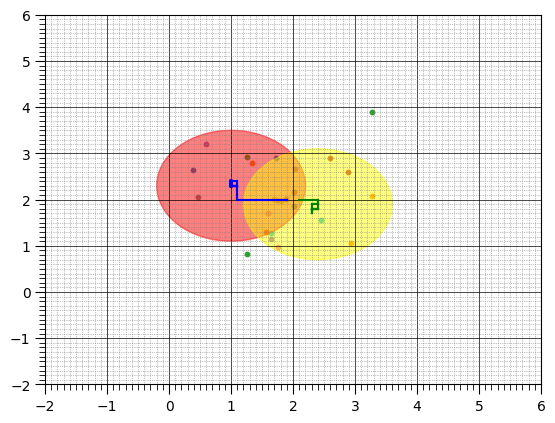

In [ ]:
state = agent.inference(num_steps=100)
agent.env.render(state=state)

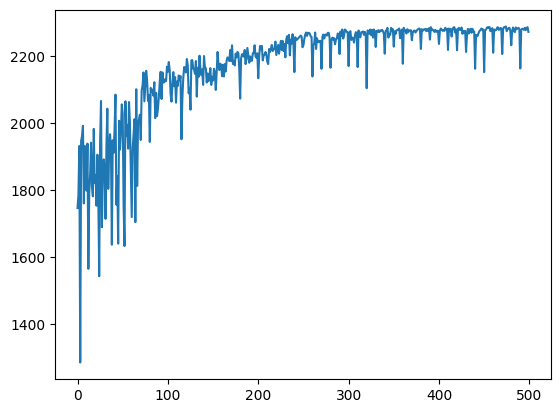

In [ ]:
plt.plot(episode_rewards)
plt.show()


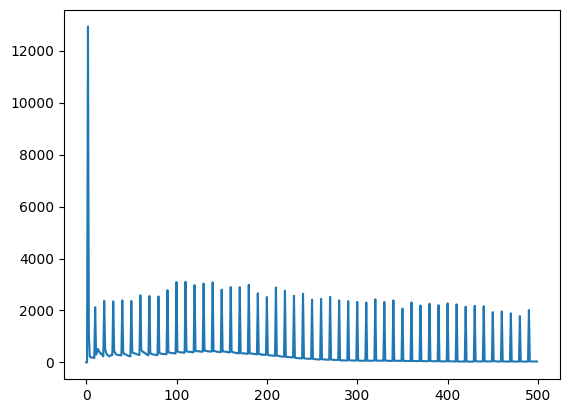

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
agent = Agent(learning_rate=0.001, gamma=0.99, epsilon_decay=0.991, batch_size=256)
episode_rewards, losses = agent.train(num_episodes=500, time_step=100)

Episode: 0, Reward: 2016, Loss: 0, epsilon: 1.0
Episode: 1, Reward: 1997, Loss: 0, epsilon: 0.991
Episode: 2, Reward: 1903, Loss: 14890.80680847168, epsilon: 0.982081
Episode: 3, Reward: 1584, Loss: 1563.6913995742798, epsilon: 0.9732422709999999
Episode: 4, Reward: 1869, Loss: 1291.176664352417, epsilon: 0.9644830905609999
Episode: 5, Reward: 1812, Loss: 908.2972106933594, epsilon: 0.9558027427459509
Episode: 6, Reward: 1797, Loss: 610.097827911377, epsilon: 0.9472005180612373
Episode: 7, Reward: 1900, Loss: 390.1915616989136, epsilon: 0.9386757133986862
Episode: 8, Reward: 1873, Loss: 264.97661435604095, epsilon: 0.930227631978098
update target network

Episode: 9, Reward: 1782, Loss: 246.79695463180542, epsilon: 0.9218555832902952
Episode: 10, Reward: 1961, Loss: 2456.0125346183777, epsilon: 0.9135588830406824
Episode: 11, Reward: 1827, Loss: 440.6586468219757, epsilon: 0.9053368530933164
Episode: 12, Reward: 1874, Loss: 294.50236201286316, epsilon: 0.8971888214154765
Episode: 13, R

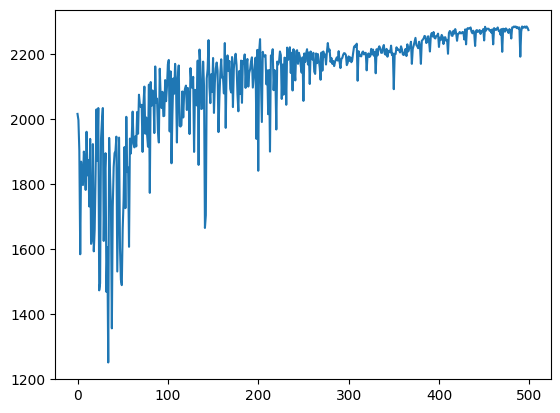

In [ ]:
plt.plot(episode_rewards)
plt.show()

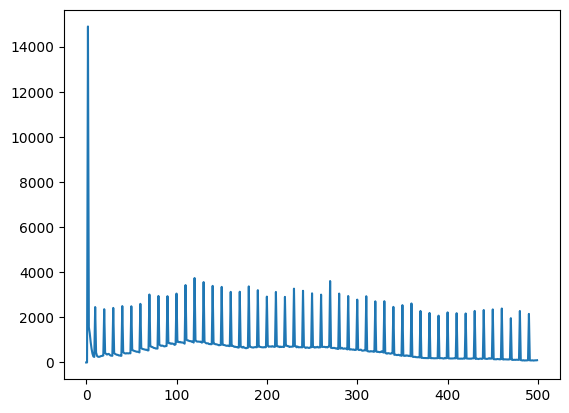

In [ ]:
plt.plot(losses)
plt.show()

Step: 0, State: [2.1 2.  1.9 2. ], Action: 23, Next State: [2.1 2.  1.9 2. ], Reward: 19
Step: 1, State: [2.2 2.  1.8 2. ], Action: 23, Next State: [2.2 2.  1.8 2. ], Reward: 20
Step: 2, State: [2.3 2.  1.7 2. ], Action: 23, Next State: [2.3 2.  1.7 2. ], Reward: 20
Step: 3, State: [2.4 2.  1.6 2. ], Action: 23, Next State: [2.4 2.  1.6 2. ], Reward: 21
Step: 4, State: [2.4 1.9 1.5 2. ], Action: 13, Next State: [2.4 1.9 1.5 2. ], Reward: 22
Step: 5, State: [2.4 1.9 1.4 2. ], Action: 3, Next State: [2.4 1.9 1.4 2. ], Reward: 23
Step: 6, State: [2.4 1.9 1.3 2. ], Action: 3, Next State: [2.4 1.9 1.3 2. ], Reward: 23
Step: 7, State: [2.4 1.9 1.2 2. ], Action: 3, Next State: [2.4 1.9 1.2 2. ], Reward: 23
Step: 8, State: [2.4 1.9 1.1 2. ], Action: 3, Next State: [2.4 1.9 1.1 2. ], Reward: 23
Step: 9, State: [2.3 1.9 1.1 2.1], Action: 16, Next State: [2.3 1.9 1.1 2.1], Reward: 22
Step: 10, State: [2.4 1.9 1.1 2.1], Action: 20, Next State: [2.4 1.9 1.1 2.1], Reward: 22
Step: 11, State: [2.4 1.

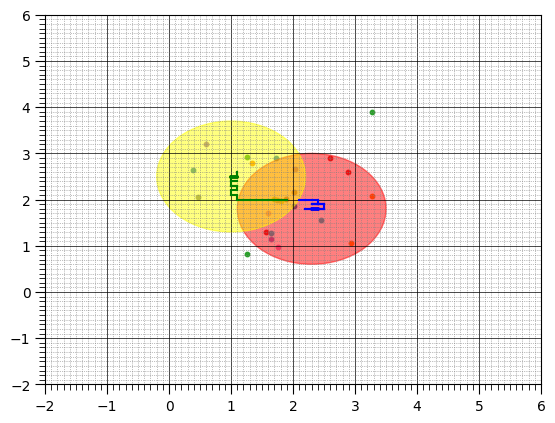

In [ ]:
state = agent.inference(num_steps=100, disk1_pos=np.array([2.0, 2.0]), disk2_pos=np.array([2.0, 2.0]))
agent.env.render(state=state)

In [ ]:
agent = Agent(learning_rate=0.001, gamma=0.99, epsilon_decay=0.991, batch_size=64)
episode_rewards, losses = agent.train(num_episodes=500, time_step=100)

Episode: 0, Reward: 1943, Loss: 13285.197692871094, epsilon: 1.0
Episode: 1, Reward: 1740, Loss: 3775.971760034561, epsilon: 0.991
Episode: 2, Reward: 1897, Loss: 702.559134721756, epsilon: 0.982081
Episode: 3, Reward: 1956, Loss: 324.717377781868, epsilon: 0.9732422709999999
Episode: 4, Reward: 1957, Loss: 206.8694807291031, epsilon: 0.9644830905609999
Episode: 5, Reward: 1952, Loss: 174.55761289596558, epsilon: 0.9558027427459509
Episode: 6, Reward: 1921, Loss: 135.57920920848846, epsilon: 0.9472005180612373
Episode: 7, Reward: 1633, Loss: 213.5824110507965, epsilon: 0.9386757133986862
Episode: 8, Reward: 1845, Loss: 219.06730568408966, epsilon: 0.930227631978098
update target network

Episode: 9, Reward: 1891, Loss: 151.49619495868683, epsilon: 0.9218555832902952
Episode: 10, Reward: 1904, Loss: 2571.764861345291, epsilon: 0.9135588830406824
Episode: 11, Reward: 1834, Loss: 306.4420212507248, epsilon: 0.9053368530933164
Episode: 12, Reward: 2003, Loss: 249.0687998533249, epsilon: 0.

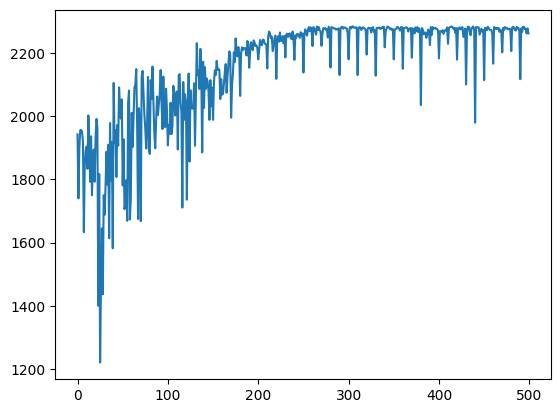

In [ ]:
plt.plot(episode_rewards)
plt.show()

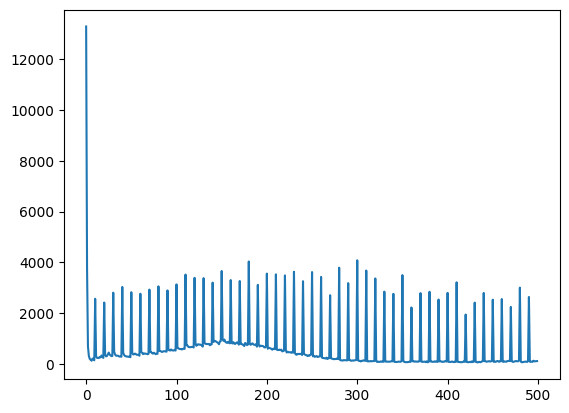

In [ ]:
plt.plot(losses)
plt.show()

Step: 0, State: [2.1 2.  1.  1.1], Action: 21, Next State: [2.1 2.  1.  1.1], Reward: 20
Step: 1, State: [2.2 2.  1.  1.2], Action: 21, Next State: [2.2 2.  1.  1.2], Reward: 21
Step: 2, State: [2.3 2.  1.  1.3], Action: 21, Next State: [2.3 2.  1.  1.3], Reward: 20
Step: 3, State: [2.4 2.  1.  1.4], Action: 21, Next State: [2.4 2.  1.  1.4], Reward: 20
Step: 4, State: [2.4 2.  1.  1.5], Action: 1, Next State: [2.4 2.  1.  1.5], Reward: 20
Step: 5, State: [2.5 2.  1.  1.6], Action: 21, Next State: [2.5 2.  1.  1.6], Reward: 20
Step: 6, State: [2.5 2.  1.  1.7], Action: 1, Next State: [2.5 2.  1.  1.7], Reward: 22
Step: 7, State: [2.5 2.  1.  1.8], Action: 1, Next State: [2.5 2.  1.  1.8], Reward: 23
Step: 8, State: [2.5 2.  1.  1.9], Action: 1, Next State: [2.5 2.  1.  1.9], Reward: 23
Step: 9, State: [2.5 2.  1.  2. ], Action: 1, Next State: [2.5 2.  1.  2. ], Reward: 22
Step: 10, State: [2.5 2.  1.  2.1], Action: 1, Next State: [2.5 2.  1.  2.1], Reward: 22
Step: 11, State: [2.5 2.  

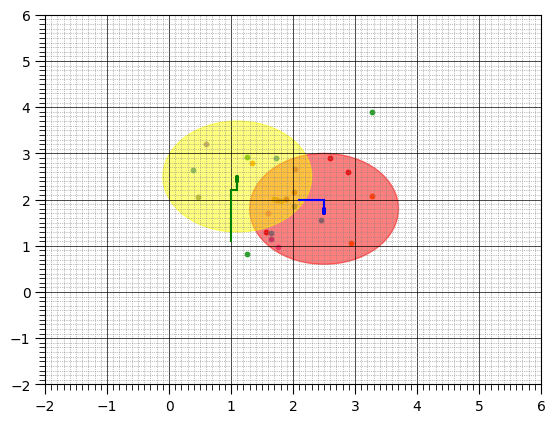

In [ ]:
state = agent.inference(num_steps=100, disk1_pos=np.array([2.0, 2.0]), disk2_pos=np.array([1.0, 1.0]))
agent.env.render(state=state)

Step: 0, State: [0.  0.1 0.  0.1], Action: 6, Next State: [0.  0.1 0.  0.1], Reward: 0
Step: 1, State: [0.  0.2 0.  0.2], Action: 6, Next State: [0.  0.2 0.  0.2], Reward: 0
Step: 2, State: [0.1 0.2 0.  0.3], Action: 21, Next State: [0.1 0.2 0.  0.3], Reward: 0
Step: 3, State: [0.1 0.3 0.  0.4], Action: 6, Next State: [0.1 0.3 0.  0.4], Reward: 0
Step: 4, State: [0.2 0.3 0.  0.5], Action: 21, Next State: [0.2 0.3 0.  0.5], Reward: 1
Step: 5, State: [0.2 0.4 0.  0.6], Action: 6, Next State: [0.2 0.4 0.  0.6], Reward: 1
Step: 6, State: [0.2 0.5 0.  0.7], Action: 6, Next State: [0.2 0.5 0.  0.7], Reward: 1
Step: 7, State: [0.2 0.6 0.  0.8], Action: 6, Next State: [0.2 0.6 0.  0.8], Reward: 1
Step: 8, State: [0.3 0.6 0.  0.9], Action: 21, Next State: [0.3 0.6 0.  0.9], Reward: 1
Step: 9, State: [0.3 0.7 0.  1. ], Action: 6, Next State: [0.3 0.7 0.  1. ], Reward: 2
Step: 10, State: [0.3 0.8 0.  1.1], Action: 6, Next State: [0.3 0.8 0.  1.1], Reward: 2
Step: 11, State: [0.3 0.9 0.  1.2], Act

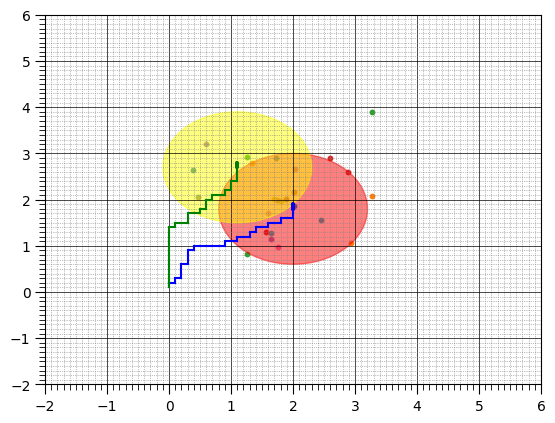

In [ ]:
state = agent.inference(num_steps=100, disk1_pos=np.array([0.0, 0.0]), disk2_pos=np.array([0.0, 0.0]))
agent.env.render(state=state)

In [ ]:
agent = Agent(learning_rate=0.001, gamma=0.99, epsilon_decay=0.994, batch_size=512)
episode_rewards, losses = agent.train(num_episodes=1000, time_step=100)

Episode: 0, Reward: 2060, Loss: 0, epsilon: 1.0
Episode: 1, Reward: 1951, Loss: 0, epsilon: 0.994
Episode: 2, Reward: 1847, Loss: 0, epsilon: 0.988036
Episode: 3, Reward: 1542, Loss: 0, epsilon: 0.982107784
Episode: 4, Reward: 992, Loss: 0, epsilon: 0.976215137296
Episode: 5, Reward: 1892, Loss: 14231.0390625, epsilon: 0.970357846472224
Episode: 6, Reward: 1819, Loss: 1711.260332107544, epsilon: 0.9645356993933907
Episode: 7, Reward: 1859, Loss: 663.2538871765137, epsilon: 0.9587484851970304
Episode: 8, Reward: 1899, Loss: 440.68200397491455, epsilon: 0.9529959942858481
update target network

Episode: 9, Reward: 1875, Loss: 452.71695923805237, epsilon: 0.947278018320133
Episode: 10, Reward: 1901, Loss: 2729.9364733695984, epsilon: 0.9415943502102122
Episode: 11, Reward: 1962, Loss: 571.6856184005737, epsilon: 0.9359447841089509
Episode: 12, Reward: 1952, Loss: 444.0190098285675, epsilon: 0.9303291154042972
Episode: 13, Reward: 1792, Loss: 373.54661297798157, epsilon: 0.9247471407118714

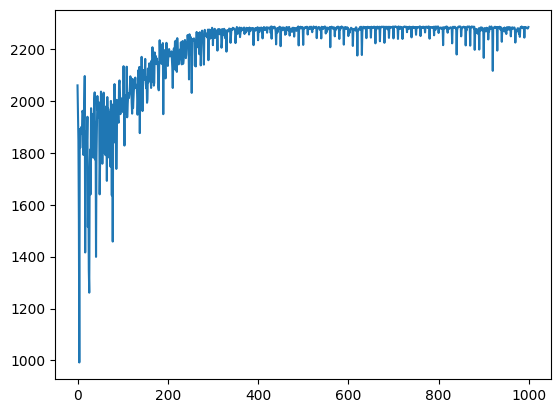

In [ ]:
plt.plot(episode_rewards)
plt.show()

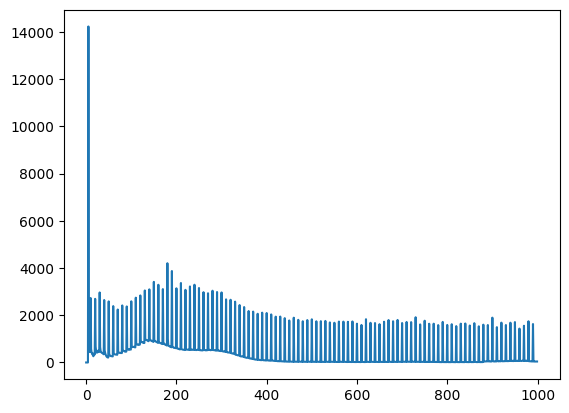

In [ ]:
plt.plot(losses)
plt.show()

Step: 0, State: [0.1 0.  0.  0.1], Action: 21, Next State: [0.1 0.  0.  0.1], Reward: 0
Step: 1, State: [0.2 0.  0.  0.2], Action: 21, Next State: [0.2 0.  0.  0.2], Reward: 0
Step: 2, State: [0.3 0.  0.  0.3], Action: 21, Next State: [0.3 0.  0.  0.3], Reward: 0
Step: 3, State: [0.4 0.  0.  0.4], Action: 21, Next State: [0.4 0.  0.  0.4], Reward: 1
Step: 4, State: [0.5 0.  0.  0.5], Action: 21, Next State: [0.5 0.  0.  0.5], Reward: 1
Step: 5, State: [0.6 0.  0.  0.6], Action: 21, Next State: [0.6 0.  0.  0.6], Reward: 1
Step: 6, State: [0.7 0.  0.  0.7], Action: 21, Next State: [0.7 0.  0.  0.7], Reward: 1
Step: 7, State: [0.8 0.  0.  0.8], Action: 21, Next State: [0.8 0.  0.  0.8], Reward: 1
Step: 8, State: [0.9 0.  0.1 0.8], Action: 24, Next State: [0.9 0.  0.1 0.8], Reward: 1
Step: 9, State: [1.  0.  0.1 0.9], Action: 21, Next State: [1.  0.  0.1 0.9], Reward: 1
Step: 10, State: [1.1 0.  0.2 0.9], Action: 24, Next State: [1.1 0.  0.2 0.9], Reward: 3
Step: 11, State: [1.1 0.1 0.2 1

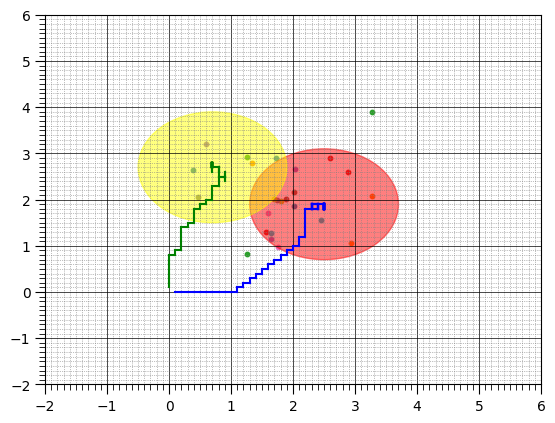

In [ ]:
state = agent.inference(num_steps=100, disk1_pos=np.array([0.0, 0.0]), disk2_pos=np.array([0.0, 0.0]))
agent.env.render(state=state)

Step: 0, State: [1.  0.1 1.  0. ], Action: 5, Next State: [1.  0.1 1.  0. ], Reward: 2
Step: 1, State: [1.  0.2 1.  0. ], Action: 5, Next State: [1.  0.2 1.  0. ], Reward: 3
Step: 2, State: [1.  0.3 1.  0. ], Action: 5, Next State: [1.  0.3 1.  0. ], Reward: 5
Step: 3, State: [1.  0.4 1.  0. ], Action: 5, Next State: [1.  0.4 1.  0. ], Reward: 5
Step: 4, State: [1.  0.5 1.  0.1], Action: 6, Next State: [1.  0.5 1.  0.1], Reward: 5
Step: 5, State: [1.  0.6 1.  0.2], Action: 6, Next State: [1.  0.6 1.  0.2], Reward: 5
Step: 6, State: [1.1 0.6 1.  0.3], Action: 21, Next State: [1.1 0.6 1.  0.3], Reward: 5
Step: 7, State: [1.2 0.6 1.  0.4], Action: 21, Next State: [1.2 0.6 1.  0.4], Reward: 6
Step: 8, State: [1.3 0.6 1.  0.5], Action: 21, Next State: [1.3 0.6 1.  0.5], Reward: 6
Step: 9, State: [1.4 0.6 1.  0.6], Action: 21, Next State: [1.4 0.6 1.  0.6], Reward: 6
Step: 10, State: [1.5 0.6 1.  0.7], Action: 21, Next State: [1.5 0.6 1.  0.7], Reward: 6
Step: 11, State: [1.6 0.6 1.  0.8], A

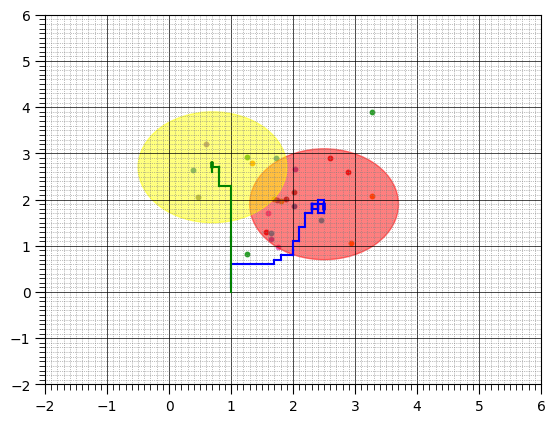

In [ ]:
state = agent.inference(num_steps=100, disk1_pos=np.array([1.0, 0.0]), disk2_pos=np.array([1.0, 0.0]))
agent.env.render(state=state)

Step: 0, State: [2.  0.1 0.1 2. ], Action: 9, Next State: [2.  0.1 0.1 2. ], Reward: 5
Step: 1, State: [2.  0.2 0.2 2. ], Action: 9, Next State: [2.  0.2 0.2 2. ], Reward: 7
Step: 2, State: [2.  0.3 0.3 2. ], Action: 9, Next State: [2.  0.3 0.3 2. ], Reward: 7
Step: 3, State: [2.  0.4 0.4 2. ], Action: 9, Next State: [2.  0.4 0.4 2. ], Reward: 8
Step: 4, State: [2.  0.4 0.4 2. ], Action: 0, Next State: [2.  0.4 0.4 2. ], Reward: 8
Step: 5, State: [2.  0.5 0.5 2. ], Action: 9, Next State: [2.  0.5 0.5 2. ], Reward: 13
Step: 6, State: [2.  0.6 0.6 2. ], Action: 9, Next State: [2.  0.6 0.6 2. ], Reward: 14
Step: 7, State: [2.  0.7 0.7 2. ], Action: 9, Next State: [2.  0.7 0.7 2. ], Reward: 17
Step: 8, State: [2.  0.8 0.7 2.1], Action: 6, Next State: [2.  0.8 0.7 2.1], Reward: 18
Step: 9, State: [2.  0.9 0.7 2.2], Action: 6, Next State: [2.  0.9 0.7 2.2], Reward: 18
Step: 10, State: [2.  1.  0.7 2.3], Action: 6, Next State: [2.  1.  0.7 2.3], Reward: 20
Step: 11, State: [2.1 1.  0.8 2.3], 

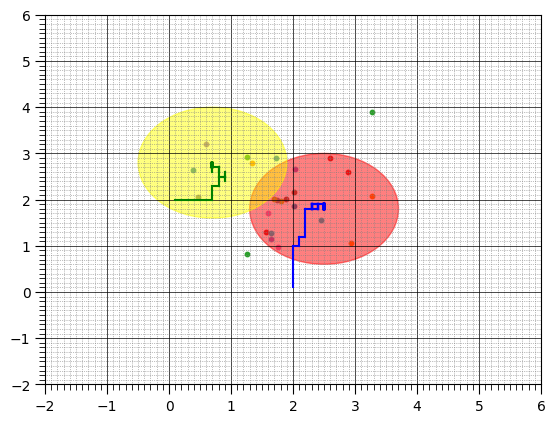

In [ ]:
state = agent.inference(num_steps=100, disk1_pos=np.array([2.0, 0.0]), disk2_pos=np.array([0.0, 2.0]))
agent.env.render(state=state)

Step: 0, State: [1.1 2.  2.9 2. ], Action: 23, Next State: [1.1 2.  2.9 2. ], Reward: 22
Step: 1, State: [1.2 2.  2.8 2. ], Action: 23, Next State: [1.2 2.  2.8 2. ], Reward: 23
Step: 2, State: [1.3 2.  2.7 2. ], Action: 23, Next State: [1.3 2.  2.7 2. ], Reward: 23
Step: 3, State: [1.4 2.  2.6 2. ], Action: 23, Next State: [1.4 2.  2.6 2. ], Reward: 23
Step: 4, State: [1.5 2.  2.5 2. ], Action: 23, Next State: [1.5 2.  2.5 2. ], Reward: 22
Step: 5, State: [1.6 2.  2.4 2. ], Action: 23, Next State: [1.6 2.  2.4 2. ], Reward: 21
Step: 6, State: [1.7 2.  2.3 2. ], Action: 23, Next State: [1.7 2.  2.3 2. ], Reward: 20
Step: 7, State: [1.8 2.  2.2 2. ], Action: 23, Next State: [1.8 2.  2.2 2. ], Reward: 20
Step: 8, State: [1.9 2.  2.1 2. ], Action: 23, Next State: [1.9 2.  2.1 2. ], Reward: 19
Step: 9, State: [2. 2. 2. 2.], Action: 23, Next State: [2. 2. 2. 2.], Reward: 18
Step: 10, State: [2.1 2.  1.9 2. ], Action: 23, Next State: [2.1 2.  1.9 2. ], Reward: 19
Step: 11, State: [2.2 2.  1.

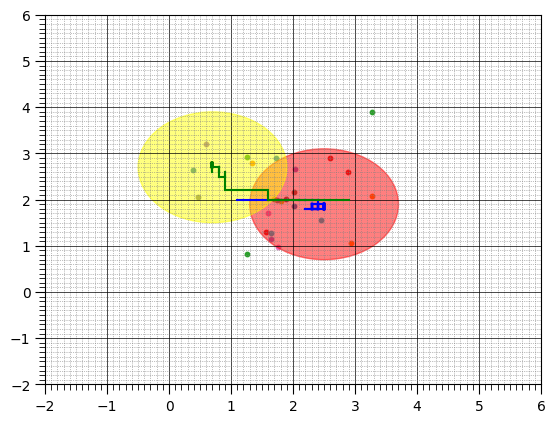

In [ ]:
state = agent.inference(num_steps=100, disk1_pos=np.array([1.0, 2.0]), disk2_pos=np.array([3.0, 2.0]))
agent.env.render(state=state)

In [ ]:
## this time change reward
agent = Agent(learning_rate=0.001, gamma=0.99, epsilon_decay=0.995, batch_size=256)
episode_rewards, losses = agent.train(num_episodes=500, time_step=100)

Episode: 0, Reward: 1677, Loss: 0, epsilon: 1.0
Episode: 1, Reward: 1680, Loss: 0, epsilon: 0.995
Episode: 2, Reward: 1981, Loss: 11579.158325195312, epsilon: 0.990025
Episode: 3, Reward: 1988, Loss: 897.7263617515564, epsilon: 0.985074875
Episode: 4, Reward: 1812, Loss: 451.7274069786072, epsilon: 0.9801495006250001
Episode: 5, Reward: 1626, Loss: 570.9828362464905, epsilon: 0.9752487531218751
Episode: 6, Reward: 1898, Loss: 569.9924278259277, epsilon: 0.9703725093562657
Episode: 7, Reward: 1645, Loss: 527.7465496063232, epsilon: 0.9655206468094844
Episode: 8, Reward: 1912, Loss: 578.2310609817505, epsilon: 0.960693043575437
update target network

Episode: 9, Reward: 1773, Loss: 466.6203429698944, epsilon: 0.9558895783575597
Episode: 10, Reward: 1834, Loss: 2529.142987728119, epsilon: 0.9511101304657719
Episode: 11, Reward: 1905, Loss: 549.610134601593, epsilon: 0.946354579813443
Episode: 12, Reward: 1669, Loss: 462.6904671192169, epsilon: 0.9416228069143757
Episode: 13, Reward: 1864,

Step: 0, State: [1.1 2.  2.9 2. ], Action: 23, Next State: [1.1 2.  2.9 2. ], Reward: 22
Step: 1, State: [1.2 2.  2.8 2. ], Action: 23, Next State: [1.2 2.  2.8 2. ], Reward: 23
Step: 2, State: [1.3 2.  2.7 2. ], Action: 23, Next State: [1.3 2.  2.7 2. ], Reward: 23
Step: 3, State: [1.4 2.  2.6 2. ], Action: 23, Next State: [1.4 2.  2.6 2. ], Reward: 23
Step: 4, State: [1.5 2.  2.5 2. ], Action: 23, Next State: [1.5 2.  2.5 2. ], Reward: 22
Step: 5, State: [1.4 2.  2.5 2. ], Action: 15, Next State: [1.4 2.  2.5 2. ], Reward: 23
Step: 6, State: [1.5 2.  2.4 2. ], Action: 23, Next State: [1.5 2.  2.4 2. ], Reward: 22
Step: 7, State: [1.6 2.  2.3 2. ], Action: 23, Next State: [1.6 2.  2.3 2. ], Reward: 21
Step: 8, State: [1.7 2.  2.2 2. ], Action: 23, Next State: [1.7 2.  2.2 2. ], Reward: 20
Step: 9, State: [1.8 2.  2.1 2. ], Action: 23, Next State: [1.8 2.  2.1 2. ], Reward: 19
Step: 10, State: [1.9 2.  2.  2. ], Action: 23, Next State: [1.9 2.  2.  2. ], Reward: 18
Step: 11, State: [2.

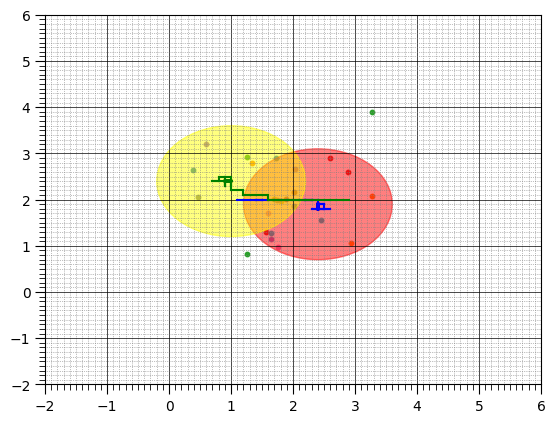

In [ ]:
state = agent.inference(num_steps=100, disk1_pos=np.array([1.0, 2.0]), disk2_pos=np.array([3.0, 2.0]))
agent.env.render(state=state)

In [ ]:
class DQNNetwork(nn.Module):
    def __init__(self, input_dim=4, output_dim=25):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc4(x)
        return x


agent = Agent(learning_rate=0.001, gamma=0.99, epsilon_decay=0.995, batch_size=64)
episode_rewards, losses = agent.train(num_episodes=1000, time_step=100)

Episode: 0, Reward: 1680, Loss: 10550.966598510742, epsilon: 1.0
Episode: 1, Reward: 1966, Loss: 5535.989200592041, epsilon: 0.995
Episode: 2, Reward: 1858, Loss: 211.45383936166763, epsilon: 0.990025
Episode: 3, Reward: 1889, Loss: 147.89240992069244, epsilon: 0.985074875
Episode: 4, Reward: 1899, Loss: 218.73189079761505, epsilon: 0.9801495006250001
Episode: 5, Reward: 1932, Loss: 273.4828305244446, epsilon: 0.9752487531218751
Episode: 6, Reward: 1997, Loss: 248.80199646949768, epsilon: 0.9703725093562657
Episode: 7, Reward: 1820, Loss: 258.11893582344055, epsilon: 0.9655206468094844
Episode: 8, Reward: 1935, Loss: 238.38460552692413, epsilon: 0.960693043575437
update target network

Episode: 9, Reward: 2018, Loss: 238.69551849365234, epsilon: 0.9558895783575597
Episode: 10, Reward: 1465, Loss: 2812.6308970451355, epsilon: 0.9511101304657719
Episode: 11, Reward: 1564, Loss: 778.4212281703949, epsilon: 0.946354579813443
Episode: 12, Reward: 2029, Loss: 708.1249318122864, epsilon: 0.94